In [139]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

## Preprocessing

In [140]:
# Load the data
df = pd.read_csv("C:/Users/vinay/Downloads/hotel_booking.csv")

In [141]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


In [142]:
df.columns 

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'name', 'email',
       'phone-number', 'credit_card'],
      dtype='object')

 Reservation Status, Reservation Status Date are Updated after is cancelled , so it is dropped


In [143]:
# Drop the 'reservation_status_date' and 'reservation_status_days_difference' columns
df = df.drop(['reservation_status_date', 'reservation_status','assigned_room_type'], axis=1)

 Removing Personal identification information

In [144]:
# check columns for percentage of missing values
missing = df.isnull().mean()*100
missing[missing > 0]


children     0.003350
country      0.408744
agent       13.686238
company     94.306893
dtype: float64

In [145]:
# Distinct agent and company values
print(df['agent'].nunique())
print(df['company'].nunique())

333
352


Since the number of agents and company is very high and there are many missing values, we can omit these columns

In [146]:
# Drop the 'agent' and 'company' columns
df = df.drop(['agent', 'company'], axis=1)

In [147]:
df.columns 

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'deposit_type', 'days_in_waiting_list',
       'customer_type', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'name', 'email', 'phone-number',
       'credit_card'],
      dtype='object')

In [148]:
df['arrival_date_year'].value_counts()

2016    56707
2017    40687
2015    21996
Name: arrival_date_year, dtype: int64

In [149]:
# Arrival date year does not make sense for the model we want to build, so we drop it
df = df.drop(['arrival_date_year'], axis=1)

## Feature Engineering

In [150]:
#Create Number of bookings column counting the number of bookings by name
df['num_bookings'] = df.groupby('name').cumcount()


In [151]:
# Keep country names with more than 1000 bookings rest as 'Other'   
country_counts = df['country'].value_counts()
df['country'] = np.where(df['country'].isin(country_counts.index[country_counts > 1000]), df['country'], 'Other')




Drop PII like name, email, phone number and credit card

In [152]:
df = df.drop(['name', 'email','phone-number', 'credit_card'], axis=1)

## Test Train and Validation Split

In [153]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=42)

In [154]:
from sklearn.model_selection import train_test_split
test, val = train_test_split(test, test_size=0.5, random_state=42)

In [155]:
print(len(train))
print(len(test))
print(len(val))

83573
17908
17909


In [156]:
# Check for null values
train.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          4
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
num_bookings                      0
dtype: int64

In [157]:
#Replace missing values with the 0 for the children column
train['children'] = train['children'].fillna(0)

## Categorical Encoding

In [158]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83573 entries, 9710 to 15795
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           83573 non-null  object 
 1   is_canceled                     83573 non-null  int64  
 2   lead_time                       83573 non-null  int64  
 3   arrival_date_month              83573 non-null  object 
 4   arrival_date_week_number        83573 non-null  int64  
 5   arrival_date_day_of_month       83573 non-null  int64  
 6   stays_in_weekend_nights         83573 non-null  int64  
 7   stays_in_week_nights            83573 non-null  int64  
 8   adults                          83573 non-null  int64  
 9   children                        83573 non-null  float64
 10  babies                          83573 non-null  int64  
 11  meal                            83573 non-null  object 
 12  country                      

<Axes: >

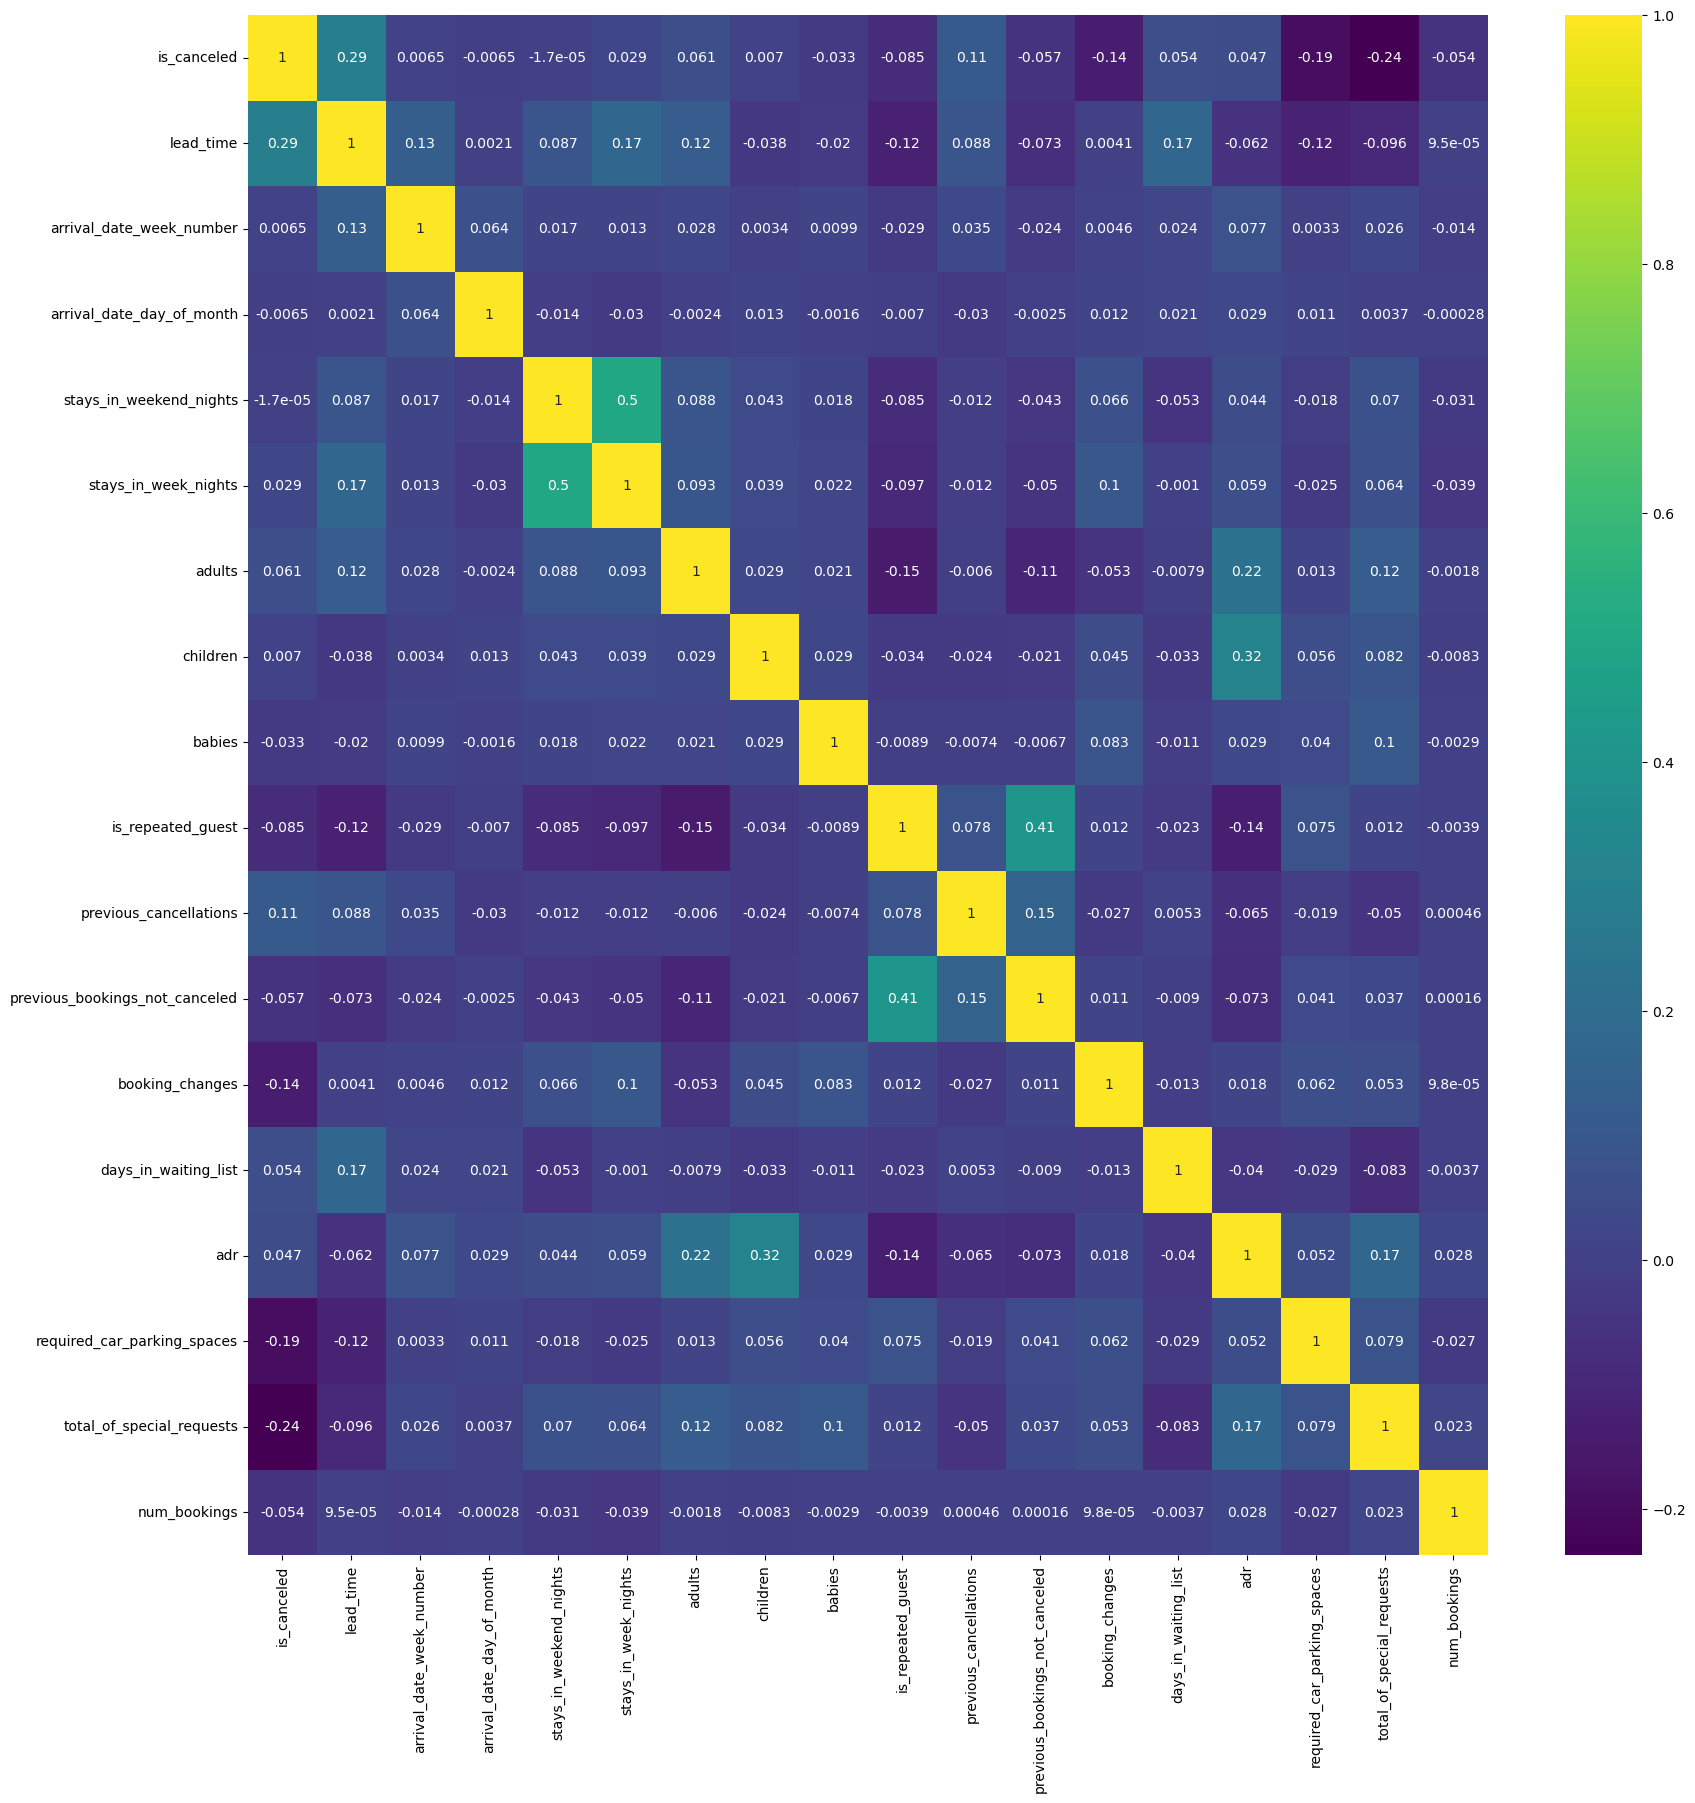

In [159]:
#Plotting a heatmap to check for correlation between the columns
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(), annot=True, cmap='viridis')

In [160]:
# Using get_dummies to convert categorical columns to numerical columns
train = pd.get_dummies(train, columns=['hotel','arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type'], drop_first=True)

## Outlier Identification and Treatment

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74]),
 [Text(1, 0, 'is_canceled'),
  Text(2, 0, 'lead_time'),
  Text(3, 0, 'arrival_date_week_number'),
  Text(4, 0, 'arrival_date_day_of_month'),
  Text(5, 0, 'stays_in_weekend_nights'),
  Text(6, 0, 'stays_in_week_nights'),
  Text(7, 0, 'adults'),
  Text(8, 0, 'children'),
  Text(9, 0, 'babies'),
  Text(10, 0, 'is_repeated_guest'),
  Text(11, 0, 'previous_cancellations'),
  Text(12, 0, 'previous_bookings_not_canceled'),
  Text(13, 0, 'booking_changes'),
  Text(14, 0, 'days_in_waiting_list'),
  Text(15, 0, 'adr'),
  Text(16, 0, 'required_car_parking_spaces'),
  Text(17, 0, 'total_of_special_requests'),
  Text(18, 0, 'num_bookings'),
  Text(19, 0, 'hotel_Resor

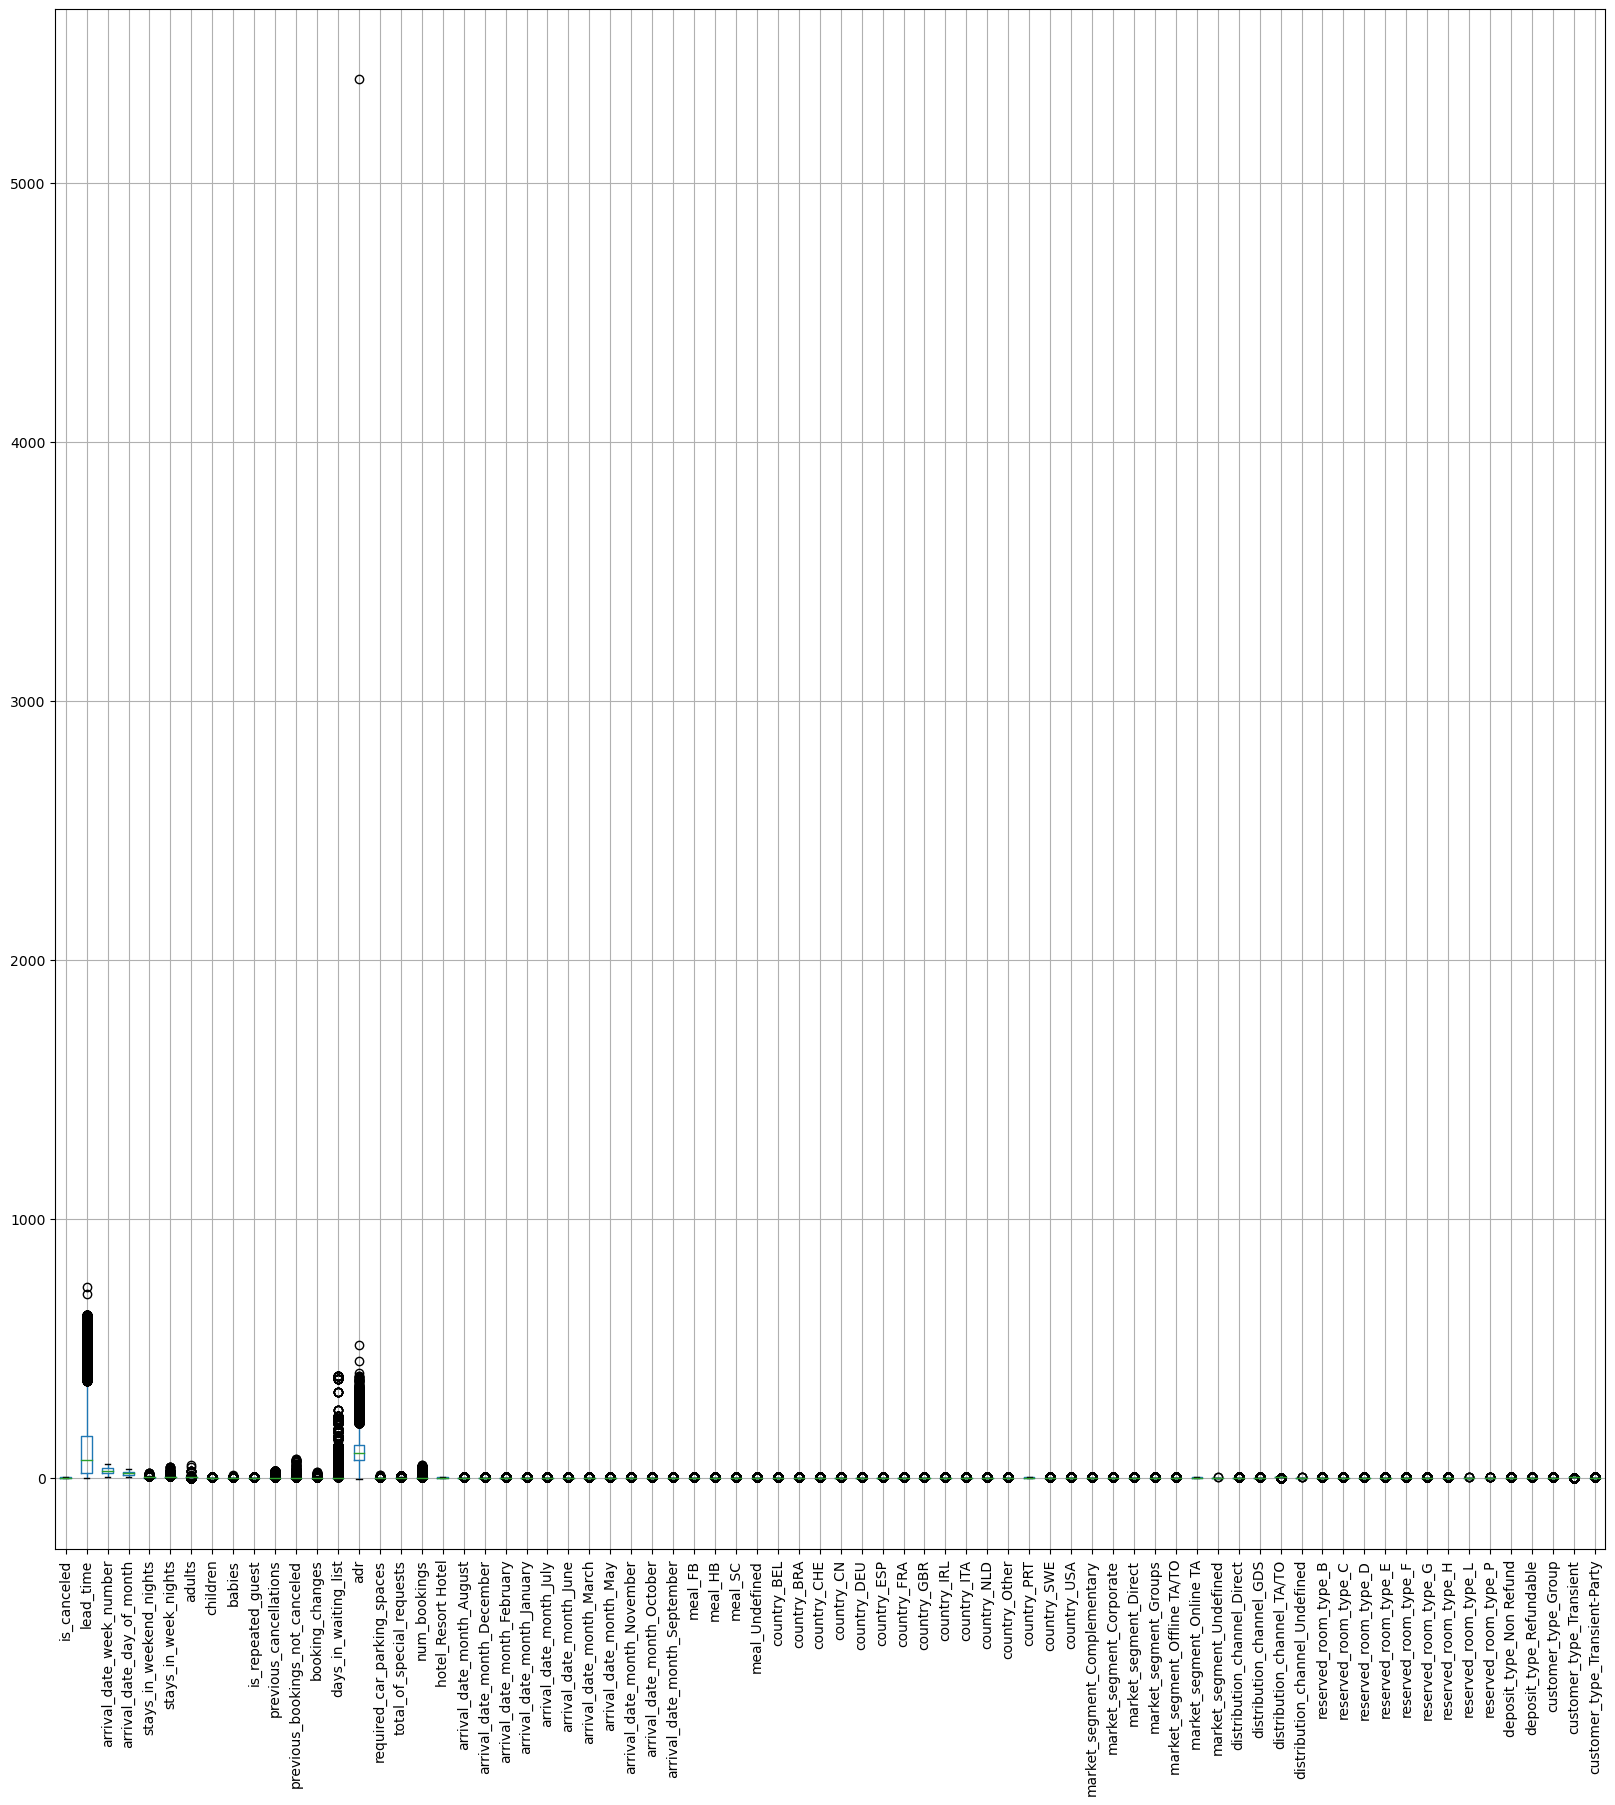

In [161]:
#Plot box plots for numerical columns to check for outliers
plt.figure(figsize=(20,20))
train.boxplot()
plt.xticks(rotation=90)


In [162]:
# Use isolation forest to remove outliers
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(n_estimators=100, random_state=42, contamination=0.02)
pred = iforest.fit_predict(train)
score = iforest.decision_function(train)

from numpy import where
anom_index = where(pred== -1)
values = train.iloc[anom_index]
values



,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
17267,1,277,41,5,4,10,1,0.0,0,0,...,0,0,0,0,0,1,0,0,1,0
10307,1,12,8,25,2,1,1,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
17498,0,277,41,6,2,5,1,0.0,0,0,...,0,0,0,0,0,0,0,0,0,1
25355,0,0,26,22,0,1,2,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
102185,0,19,48,26,4,7,0,0.0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25342,0,160,25,16,2,5,2,1.0,1,0,...,0,1,0,0,0,0,0,0,1,0
27266,0,333,34,24,1,3,2,0.0,0,1,...,0,0,0,0,0,0,0,0,1,0
24300,0,75,20,10,2,5,2,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
92093,0,17,27,29,0,2,3,1.0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [163]:
#Remove outliers
train = train.drop(values.index)


# Target Vs Features

In [164]:
# Split the data into features and target
X_train = train.drop('is_canceled', axis=1)
y_train = train['is_canceled']

# Feature Selection

In [165]:

randomforest = RandomForestClassifier(random_state=42)

model = randomforest.fit(X_train,y_train)

model.feature_importances_

pd.DataFrame(list(zip(X_train.columns,model.feature_importances_)), columns = ['predictor','feature importance']).sort_values("feature importance")[:10]

,predictor,feature importance
66,reserved_room_type_L,0.000007
54,market_segment_Undefined,0.000016
58,distribution_channel_Undefined,0.000056
67,reserved_room_type_P,0.000170
69,deposit_type_Refundable,0.000228
56,distribution_channel_GDS,0.000245
70,customer_type_Group,0.000304
48,market_segment_Complementary,0.000367
65,reserved_room_type_H,0.000514
7,babies,0.000816


In [166]:
#Drop columns with low feature importance 'reserved_room_type_L','market_segment_Undefined','distribution_channel_Undefined'
X_train = X_train.drop(['reserved_room_type_L','market_segment_Undefined','distribution_channel_Undefined'], axis=1)


In [167]:
X_train.shape

(81901, 70)

## Standardize the Data

In [168]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

## Preprocess Validation Data

In [169]:
# Check for null values
val.isnull().sum()
#Replace missing values with the 0 for the children column
val['children'] = val['children'].fillna(0)

# Using get_dummies to convert categorical columns to numerical columns
val = pd.get_dummies(val, columns=['hotel','arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type'], drop_first=True)

# Split the data into features and target
X_val = val.drop('is_canceled', axis=1)
y_val = val['is_canceled']

#Drop columns with low feature importance 'reserved_room_type_L','market_segment_Undefined','distribution_channel_Undefined' if these columns exist
if 'reserved_room_type_L' in X_val.columns:
    X_val = X_val.drop(['reserved_room_type_L'], axis=1)
if 'market_segment_Undefined' in X_val.columns:
    X_val = X_val.drop(['market_segment_Undefined'], axis=1)
if 'distribution_channel_Undefined' in X_val.columns:
    X_val = X_val.drop(['distribution_channel_Undefined'], axis=1)

#standardize the data
sc = StandardScaler()
X_val = sc.fit_transform(X_val)





In [170]:
X_val.shape

(17909, 70)

## Base Model Classifier

In [176]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train_std, y_train)

DummyClassifier()

In [177]:
#Accuracy of the dummy classifier
dummy_clf.score(X_val, y_val)


0.629515885867441

In [178]:
print(metrics.confusion_matrix(y_val, dummy_clf.predict(X_val)))

[[11274     0]
 [ 6635     0]]


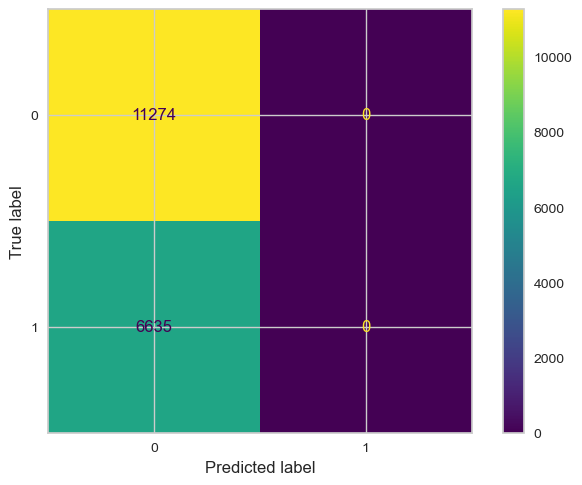

In [206]:
#plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(y_val, dummy_clf.predict(X_val)))
disp.plot()


In [180]:
print(metrics.classification_report(dummy_clf.predict(X_val), y_val, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.630     0.773     17909
           1      0.000     0.000     0.000         0

    accuracy                          0.630     17909
   macro avg      0.500     0.315     0.386     17909
weighted avg      1.000     0.630     0.773     17909



## Evaluation Metrics

In [181]:
#ROC Curve

def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [182]:
# PR Curve
def plot_pr_curve(precision, recall, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

In [215]:
#Classification Score
def clf_score(clf, X_train, y_train, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(y_train, clf.predict(X_train)))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

    elif train == False:
        print("Validation Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_val, clf.predict(X_val))))
        
        precision, recall, _ = precision_recall_curve(y_val, clf.predict(X_val))
        average_precision = average_precision_score(y_val, clf.predict(X_val))
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_val, clf.predict(X_val))
        roc_auc = roc_auc_score(y_val, clf.predict(X_val))
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_val, clf.predict(X_val))))
        print("Confusion Matrix: \n {}\n".format(ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(y_val, clf.predict(X_val)))))
        ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(y_val, clf.predict(X_val))).plot()
        print("End of validation Result\n")

## Dealing with Imbalanced Data

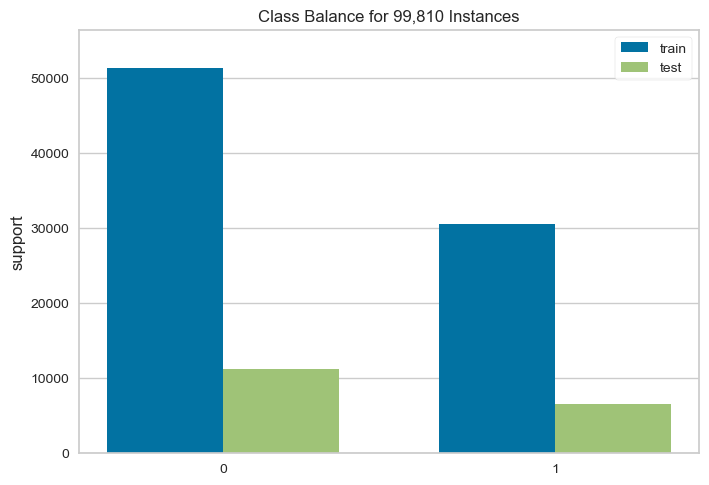

<Axes: title={'center': 'Class Balance for 99,810 Instances'}, ylabel='support'>

In [186]:
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
visualizer = ClassBalance(labels=[0, 1])

visualizer.fit(y_train, y_val)        # Fit the data to the visualizer
visualizer.show()  

We can see an imbalanced dataset, O has more instances than 1. This makes sense due to the nature of the classification task that there would be more non cancelled bookings than cancelled ones

## Oversampling

In [187]:
print('Before OverSampling, the shape of X: {}'.format(X_train_std.shape)) 
print('Before OverSampling, the shape of y: {} \n'.format(y_train.shape)) 
  
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {}".format(sum(y_train == 0)))

Before OverSampling, the shape of X: (81901, 70)
Before OverSampling, the shape of y: (81901,) 

Before OverSampling, counts of label '1': 30583
Before OverSampling, counts of label '0': 51318


In [191]:
#Use RandomOverSampler to handle imbalanced data
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_std, y_train)

pd.Series(y_train_ros).value_counts()


1    51318
0    51318
Name: is_canceled, dtype: int64

In [192]:
print('After OverSampling, the shape of X: {}'.format(X_train_ros.shape)) 
print('After OverSampling, the shape of y: {} \n'.format(y_train_ros.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_ros == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_ros == 0)))

After OverSampling, the shape of X: (102636, 70)
After OverSampling, the shape of y: (102636,) 

After OverSampling, counts of label '1': 51318
After OverSampling, counts of label '0': 51318


In [193]:
X_train_ros

array([[ 0.16784248,  1.90386322,  1.27488219, ..., -0.0668149 ,
         0.57067194, -0.509841  ],
       [-0.78627763,  0.20790195,  0.70520848, ..., -0.0668149 ,
        -1.75232025,  1.96139579],
       [-0.15955168, -0.82442231,  0.02160004, ..., -0.0668149 ,
         0.57067194, -0.509841  ],
       ...,
       [ 0.55136135, -0.08704784,  1.04701271, ..., -0.0668149 ,
         0.57067194, -0.509841  ],
       [ 0.76650608, -0.38199763,  1.61668641, ..., -0.0668149 ,
         0.57067194, -0.509841  ],
       [ 2.34735214,  1.01901386, -1.00381263, ..., -0.0668149 ,
        -1.75232025,  1.96139579]])

In [194]:
#Using SMOTE to handle imbalanced data
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_std, y_train)

pd.Series(y_train_smote).value_counts()

print('After OverSampling, the shape of X: {}'.format(X_train_smote.shape))
print('After OverSampling, the shape of y: {} \n'.format(y_train_smote.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_smote == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_smote == 0)))


After OverSampling, the shape of X: (102636, 70)
After OverSampling, the shape of y: (102636,) 

After OverSampling, counts of label '1': 51318
After OverSampling, counts of label '0': 51318


## Converting to Dataframe

In [197]:
#converting to dataframe
train_X = X_train
cols = list(train_X)

X_train_ros=pd.DataFrame(X_train_ros)
X_train_ros.columns=cols
#Renaming column name of Target variable
y_train_ros=pd.DataFrame(y_train_ros)
y_train_ros.columns = ['is_canceled']
scaled_train_df = pd.concat([X_train_ros,y_train_ros], axis=1)
scaled_train_df

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,is_canceled
0,0.167842,1.903863,1.274882,-0.933934,0.828988,0.243584,-0.255013,-0.076438,-0.169297,-0.108246,...,-0.157032,-0.12685,-0.067183,-0.010483,-0.375204,-0.035485,-0.066815,0.570672,-0.509841,1
1,-0.786278,0.207902,0.705208,-0.933934,-0.255431,0.243584,-0.255013,-0.076438,-0.169297,-0.108246,...,-0.157032,-0.12685,-0.067183,-0.010483,-0.375204,-0.035485,-0.066815,-1.752320,1.961396,1
2,-0.159552,-0.824422,0.021600,1.106021,0.286779,1.961909,-0.255013,-0.076438,-0.169297,-0.108246,...,-0.157032,-0.12685,-0.067183,-0.010483,-0.375204,-0.035485,-0.066815,0.570672,-0.509841,0
3,-0.973360,-1.635534,-1.573486,-0.933934,-0.797641,-1.474742,-0.255013,-0.076438,5.906777,-0.108246,...,-0.157032,-0.12685,-0.067183,-0.010483,-0.375204,-0.035485,-0.066815,0.570672,-0.509841,0
4,-0.580487,0.871539,0.819143,-0.933934,-0.797641,0.243584,-0.255013,-0.076438,-0.169297,-0.108246,...,-0.157032,-0.12685,-0.067183,-0.010483,-0.375204,-0.035485,-0.066815,0.570672,-0.509841,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102631,2.197686,0.871539,0.591274,0.086043,-0.797641,0.243584,-0.255013,-0.076438,-0.169297,1.407475,...,-0.157032,-0.12685,-0.067183,-0.010483,2.665219,-0.035485,-0.066815,-1.752320,-0.509841,1
102632,0.280092,-0.308260,-1.003813,-0.933934,-0.255431,0.243584,-0.255013,-0.076438,-0.169297,-0.108246,...,-0.157032,-0.12685,-0.067183,-0.010483,2.665219,-0.035485,-0.066815,0.570672,-0.509841,1
102633,0.551361,-0.087048,1.047013,0.086043,-0.797641,0.243584,-0.255013,-0.076438,-0.169297,-0.108246,...,-0.157032,-0.12685,-0.067183,-0.010483,2.665219,-0.035485,-0.066815,0.570672,-0.509841,1
102634,0.766506,-0.381998,1.616686,-0.933934,-0.255431,0.243584,-0.255013,-0.076438,-0.169297,-0.108246,...,-0.157032,-0.12685,-0.067183,-0.010483,2.665219,-0.035485,-0.066815,0.570672,-0.509841,1


<Axes: xlabel='is_canceled', ylabel='count'>

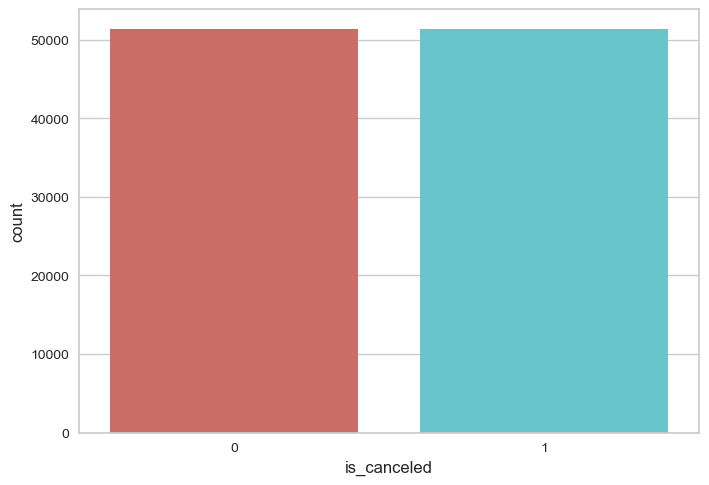

In [198]:
#Plot value counts of the target variable
sns.countplot(x='is_canceled', data=scaled_train_df, palette='hls')

The training data is now balanced

## Model Building

## 1. Dummy Classifier

In [199]:
from sklearn.dummy import DummyClassifier

clf_dummy = DummyClassifier()
clf_dummy.fit(X_train_ros, y_train_ros)

DummyClassifier()

Validation Result:

accuracy score: 0.6295



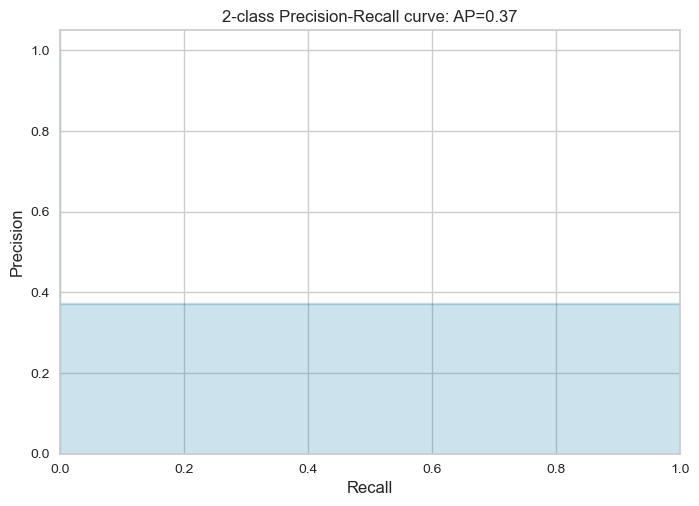

roc auc score: 0.5



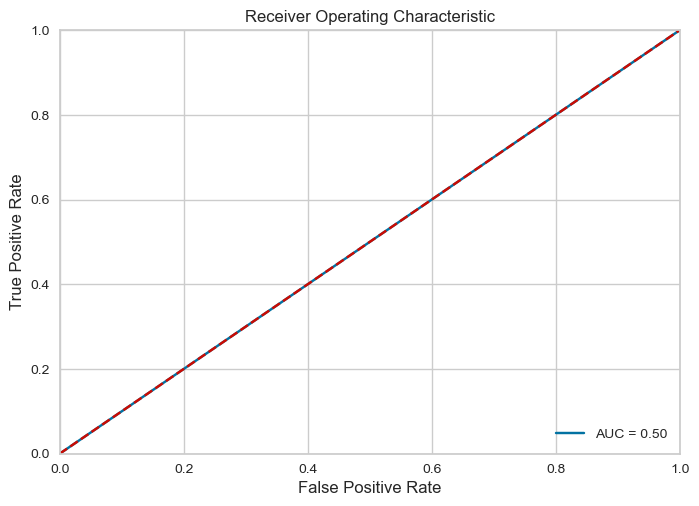

Classification Report: 
               precision    recall  f1-score   support

           0       0.63      1.00      0.77     11274
           1       0.00      0.00      0.00      6635

    accuracy                           0.63     17909
   macro avg       0.31      0.50      0.39     17909
weighted avg       0.40      0.63      0.49     17909


Confusion Matrix: 

End of validation Result



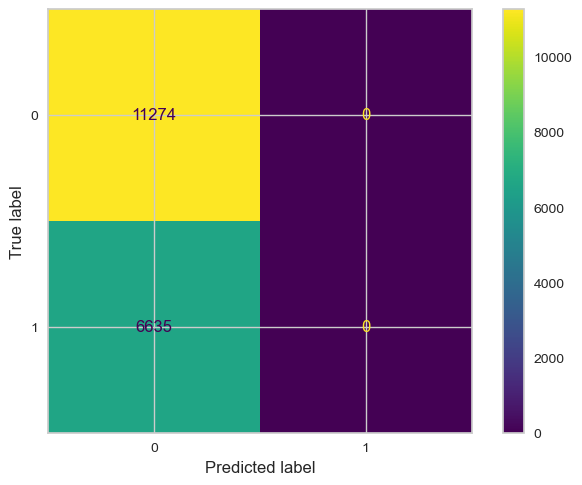

In [216]:
clf_score(clf_dummy, X_val, y_val, train=False)

## Logistic Regression

Validation Result:

accuracy score: 0.8042



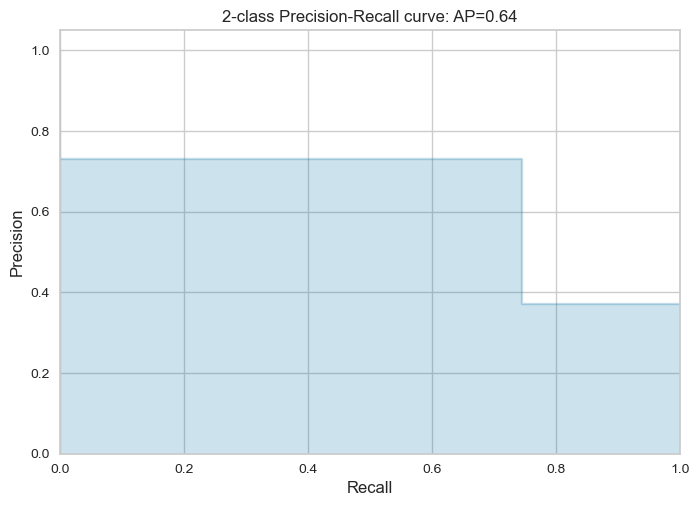

roc auc score: 0.7922164608660697



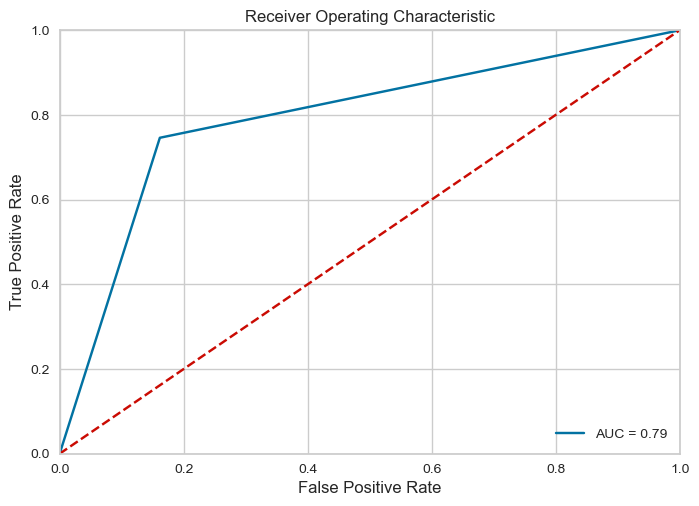

Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.84      0.84     11274
           1       0.73      0.75      0.74      6635

    accuracy                           0.80     17909
   macro avg       0.79      0.79      0.79     17909
weighted avg       0.81      0.80      0.80     17909


Confusion Matrix: 

End of validation Result



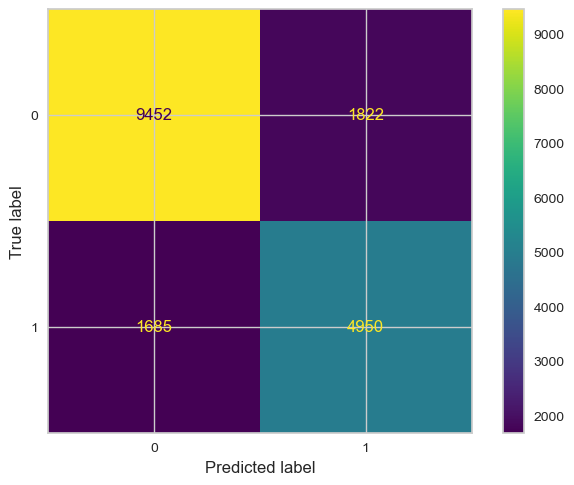

In [222]:
from sklearn.linear_model import LogisticRegression

clf_log_reg = LogisticRegression(C=0.0001, random_state=42, max_iter=1000)
clf_log_reg.fit(X_train_ros, y_train_ros)

clf_score(clf_log_reg, X_val, y_val, train=False)

## Random Forest

Validation Result:

accuracy score: 0.8807



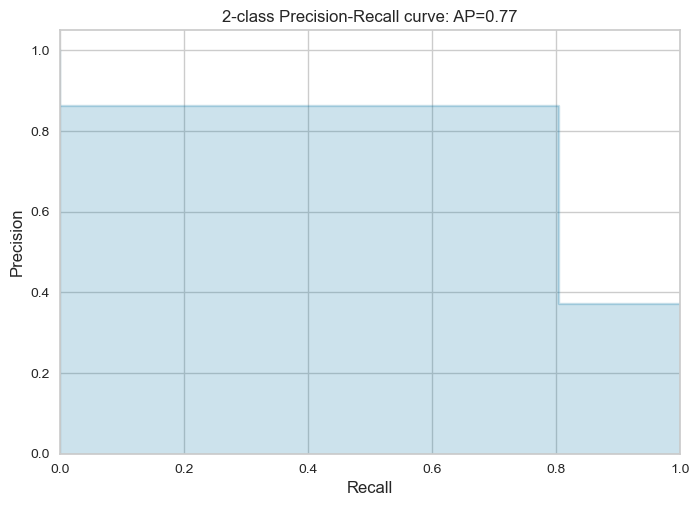

roc auc score: 0.8653923192107694



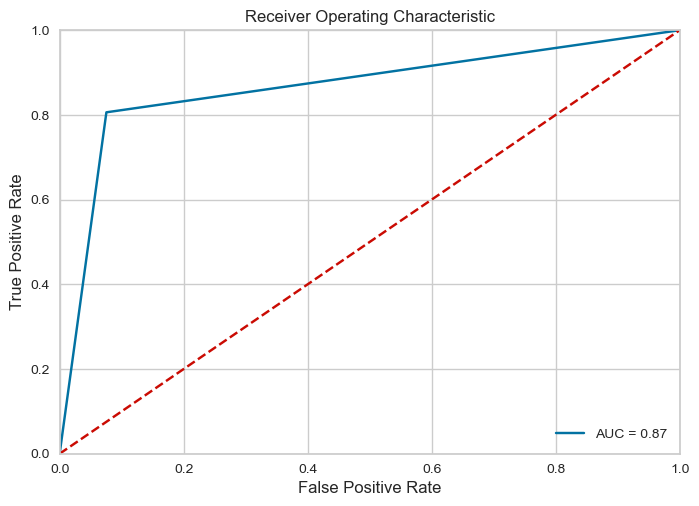

Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.92      0.91     11274
           1       0.86      0.81      0.83      6635

    accuracy                           0.88     17909
   macro avg       0.88      0.87      0.87     17909
weighted avg       0.88      0.88      0.88     17909


Confusion Matrix: 

End of validation Result



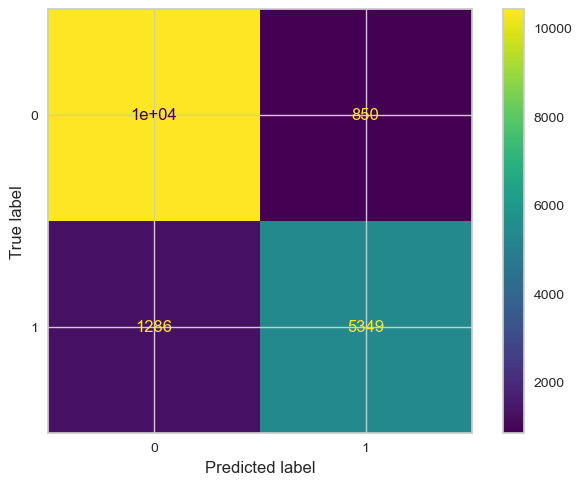

In [223]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=40, random_state=42)
clf_rf.fit(X_train_ros, y_train_ros)

clf_score(clf_rf, X_val, y_val,train=False)

## KNN

Validation Result:

accuracy score: 0.8148



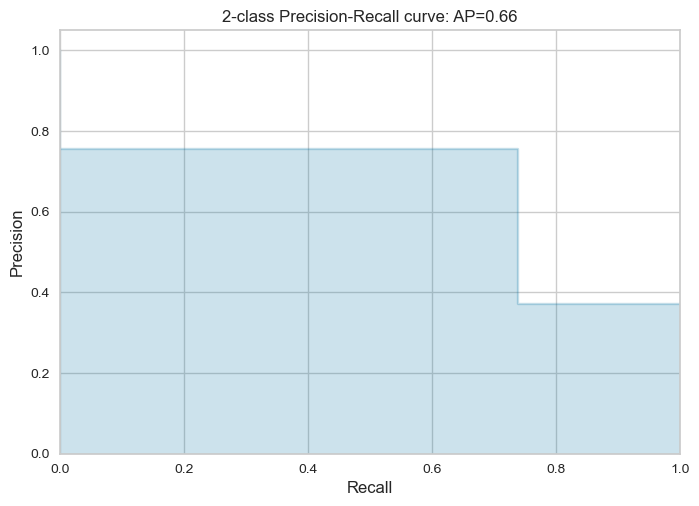

roc auc score: 0.7994469539252375



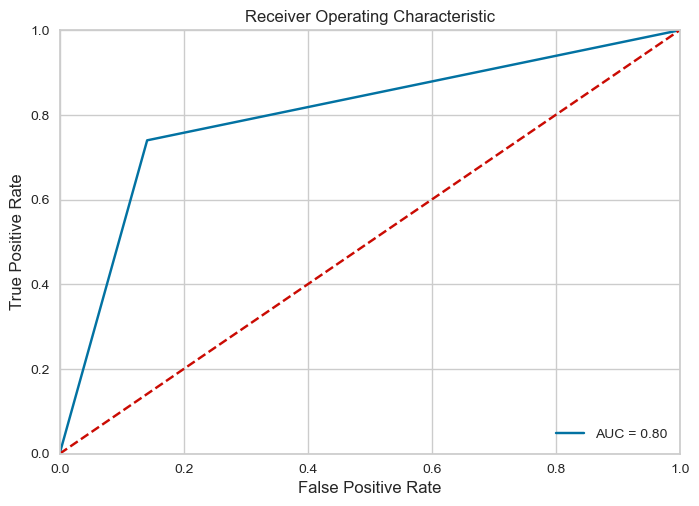

Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.86      0.85     11274
           1       0.76      0.74      0.75      6635

    accuracy                           0.81     17909
   macro avg       0.80      0.80      0.80     17909
weighted avg       0.81      0.81      0.81     17909


Confusion Matrix: 

End of validation Result



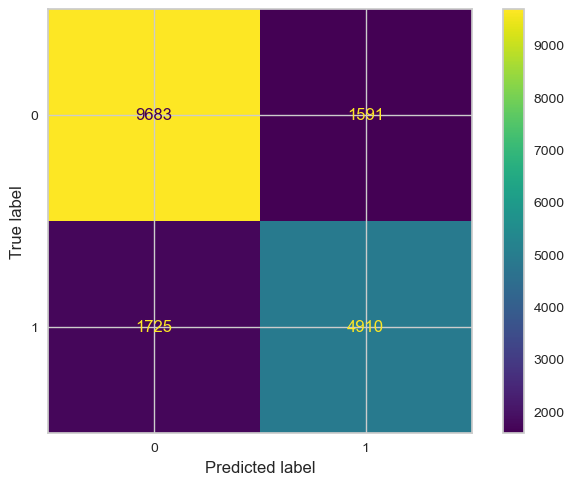

In [217]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn=KNeighborsClassifier(n_neighbors=4)
clf_knn.fit(X_train_ros, y_train_ros)

clf_score(clf_knn, X_val, y_val, train=False)

## XGBOOST

Validation Result:

accuracy score: 0.5547



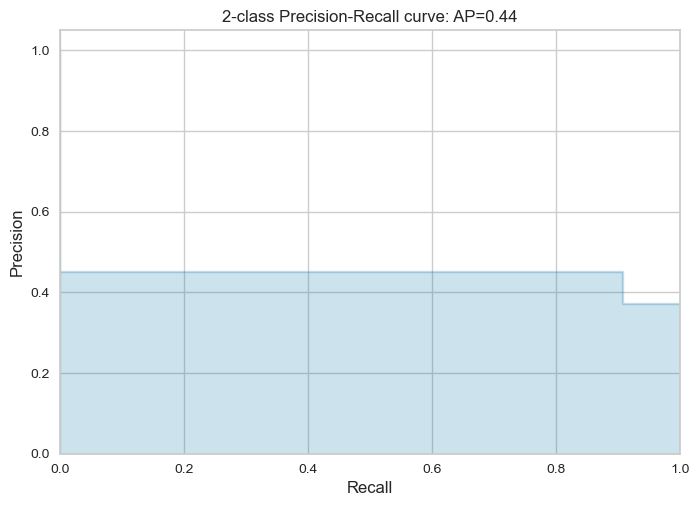

roc auc score: 0.6275635238644872



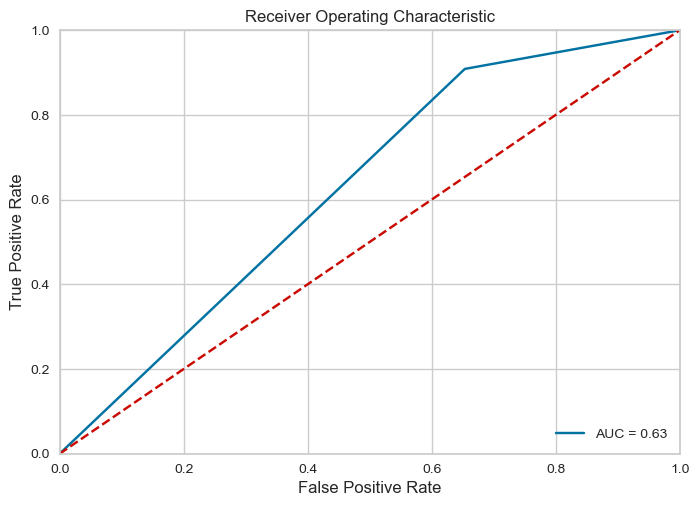

Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.35      0.49     11274
           1       0.45      0.91      0.60      6635

    accuracy                           0.55     17909
   macro avg       0.66      0.63      0.55     17909
weighted avg       0.71      0.55      0.53     17909


Confusion Matrix: 

End of validation Result



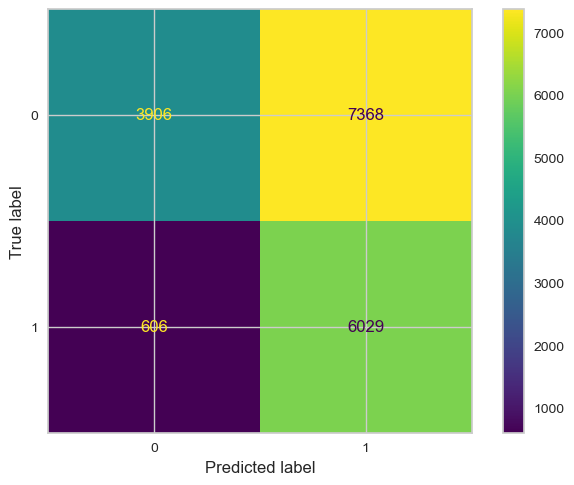

In [218]:
import xgboost as xgb

clf_xgb=xgb.XGBClassifier(random_state=1, learning_rate=0.01)
clf_xgb.fit(X_train_smote, y_train_smote)

clf_score(clf_xgb, X_val, y_val, train=False)

## Adaboost

Validation Result:

accuracy score: 0.8214



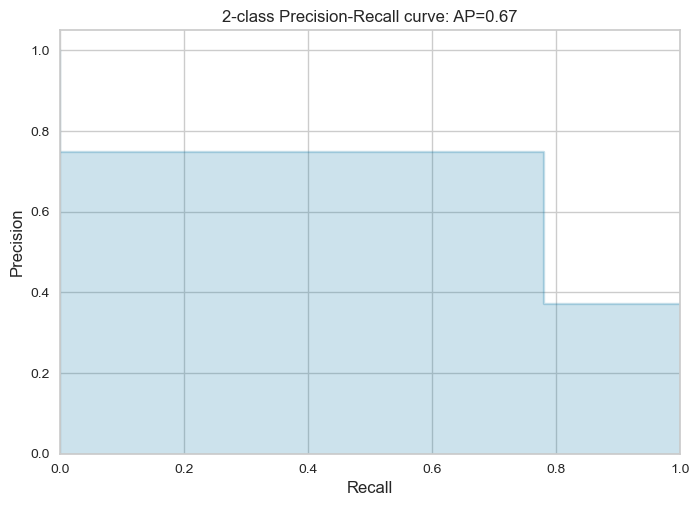

roc auc score: 0.8131941249942015



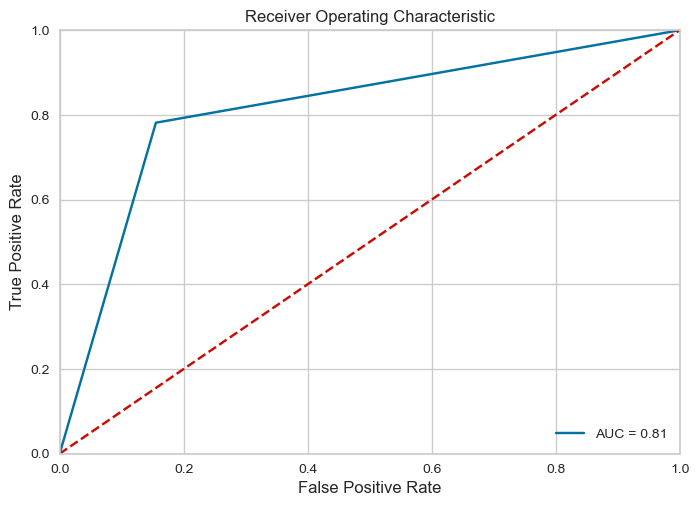

Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.84      0.86     11274
           1       0.75      0.78      0.76      6635

    accuracy                           0.82     17909
   macro avg       0.81      0.81      0.81     17909
weighted avg       0.82      0.82      0.82     17909


Confusion Matrix: 

End of validation Result



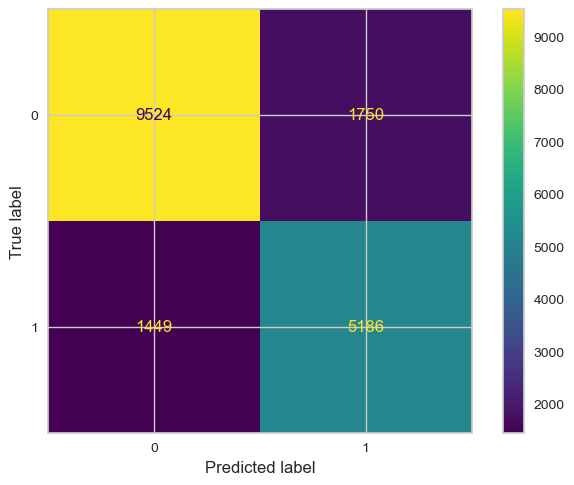

In [219]:
from sklearn.ensemble import AdaBoostClassifier

clf_ada_boost = AdaBoostClassifier(n_estimators=40, random_state=42)
clf_ada_boost.fit(X_train_ros, y_train_ros)

clf_score(clf_ada_boost, X_val, y_val,  train=False)

## CatBoost

0:	learn: 0.5403989	total: 170ms	remaining: 170ms
1:	learn: 0.4693685	total: 192ms	remaining: 0us
proba =  [[0.50053288 0.49946712]
 [0.7734856  0.2265144 ]
 [0.82878866 0.17121134]
 ...
 [0.50053288 0.49946712]
 [0.50053288 0.49946712]
 [0.93054165 0.06945835]]
Validation Result:

accuracy score: 0.7536



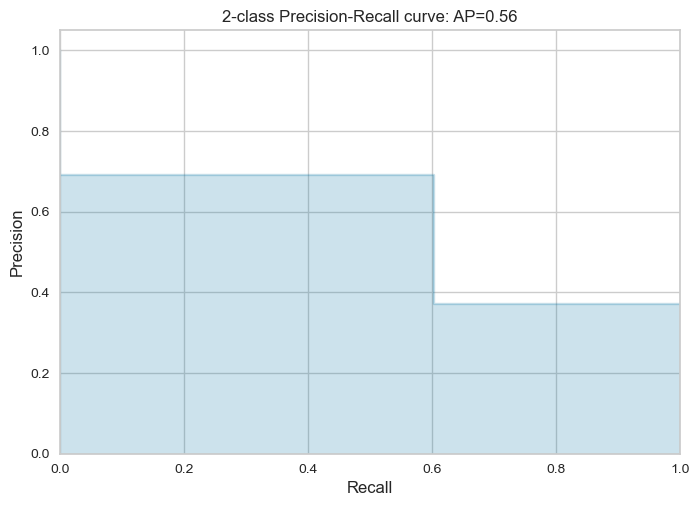

roc auc score: 0.7226088088190058



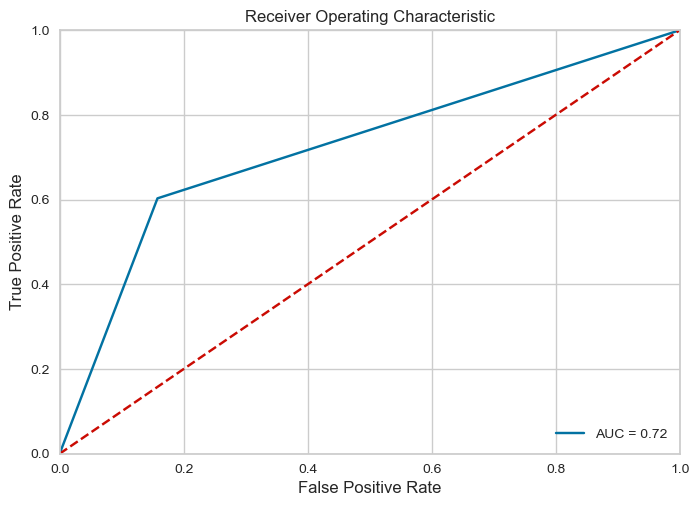

Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.84      0.81     11274
           1       0.69      0.60      0.64      6635

    accuracy                           0.75     17909
   macro avg       0.74      0.72      0.73     17909
weighted avg       0.75      0.75      0.75     17909


Confusion Matrix: 

End of validation Result



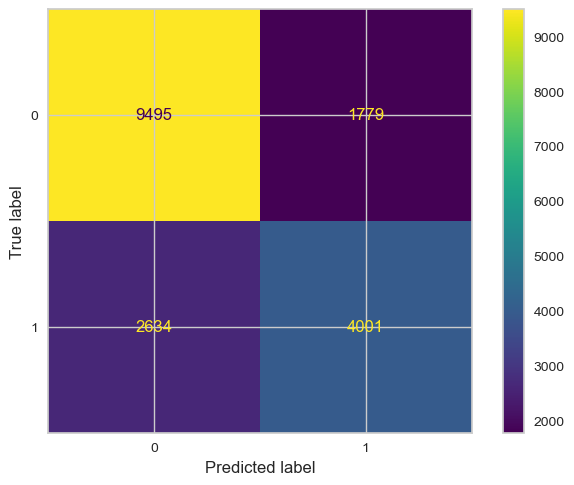

In [221]:
from catboost import CatBoostClassifier, Pool

clf_cat_boost = CatBoostClassifier(iterations=2,
                                   depth=2,
                                   learning_rate=1,
                                   loss_function='Logloss',
                                   verbose=True)
# train the model
clf_cat_boost.fit(X_train_ros, y_train_ros)

# make the prediction using the resulting model
preds_class = clf_cat_boost.predict(X_val)
preds_proba = clf_cat_boost.predict_proba(X_val)
#print("class = ", preds_class)
print("proba = ", preds_proba)

clf_score(clf_cat_boost, X_val, y_val,  train=False)

## Stacked Model

0:	learn: 0.5403989	total: 15.8ms	remaining: 15.8ms
1:	learn: 0.4693685	total: 33ms	remaining: 0us
0:	learn: 0.5416558	total: 15.8ms	remaining: 15.8ms
1:	learn: 0.4707357	total: 30.3ms	remaining: 0us
0:	learn: 0.5409407	total: 20.1ms	remaining: 20.1ms
1:	learn: 0.4694293	total: 33.9ms	remaining: 0us
0:	learn: 0.5393101	total: 27.6ms	remaining: 27.6ms
1:	learn: 0.4689082	total: 52ms	remaining: 0us
0:	learn: 0.5399262	total: 24.3ms	remaining: 24.3ms
1:	learn: 0.4686531	total: 46.4ms	remaining: 0us
0:	learn: 0.5428319	total: 20.2ms	remaining: 20.2ms
1:	learn: 0.4704657	total: 39.8ms	remaining: 0us
Validation Result:

accuracy score: 0.8789



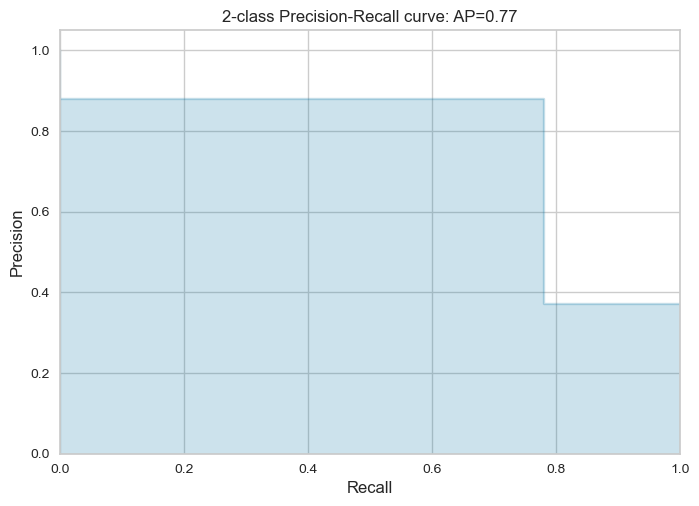

roc auc score: 0.858732752527673



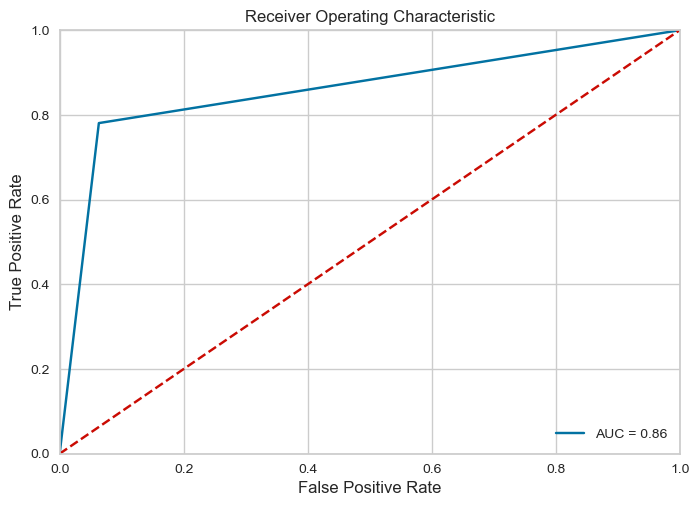

Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.94      0.91     11274
           1       0.88      0.78      0.83      6635

    accuracy                           0.88     17909
   macro avg       0.88      0.86      0.87     17909
weighted avg       0.88      0.88      0.88     17909


Confusion Matrix: 

End of validation Result



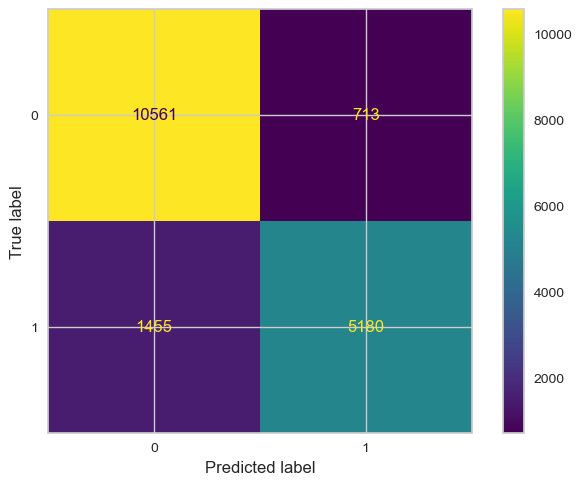

In [224]:
# Stacking Random Forest, KNN, Logistic Regression, AdaBoost and  CatBoost
from sklearn.ensemble import StackingClassifier

estimators = [
    ('rf', RandomForestClassifier(n_estimators=40, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=4)),
    ('log_reg', LogisticRegression(C=0.0001, random_state=42, max_iter=1000)),
    ('ada_boost', AdaBoostClassifier(n_estimators=40, random_state=42)),
    ('cat_boost', CatBoostClassifier(iterations=2, depth=2, learning_rate=1, loss_function='Logloss', verbose=True))
]

clf_stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf_stack.fit(X_train_ros, y_train_ros)

clf_score(clf_stack, X_val, y_val, train=False)

